In [7]:
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import HTML
from loguru import logger
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [ ]:
%%capture cap
%run auth/cacheb-authentication.py

In [ ]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

In [ ]:
url = "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr"
latitude_range = [35.0, 71.0]
longitude_range = [-25.0, 40.0]
start_date = "2020-03-01"
end_date = "2020-03-01"

data = xr.open_dataset(
    url,
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})

hr_data = data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                longitude=slice(longitude_range[0],longitude_range[1]),
                time=slice(start_date, end_date))

data_vars = list(hr_data.data_vars)
hr_data

<xarray.Dataset> Size: 4GB
Dimensions:           (time: 24, latitude: 819, longitude: 1479)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 7kB 35.01 35.05 35.1 ... 70.92 70.97
  * longitude         (longitude) float64 12kB -24.96 -24.92 ... 39.95 39.99
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 192B 2020-03-01 ... 2020-03-01T23...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
hr_data = hr_data[["t2m", "u10", "v10","skt"]].load()
hr_data = hr_data.load()

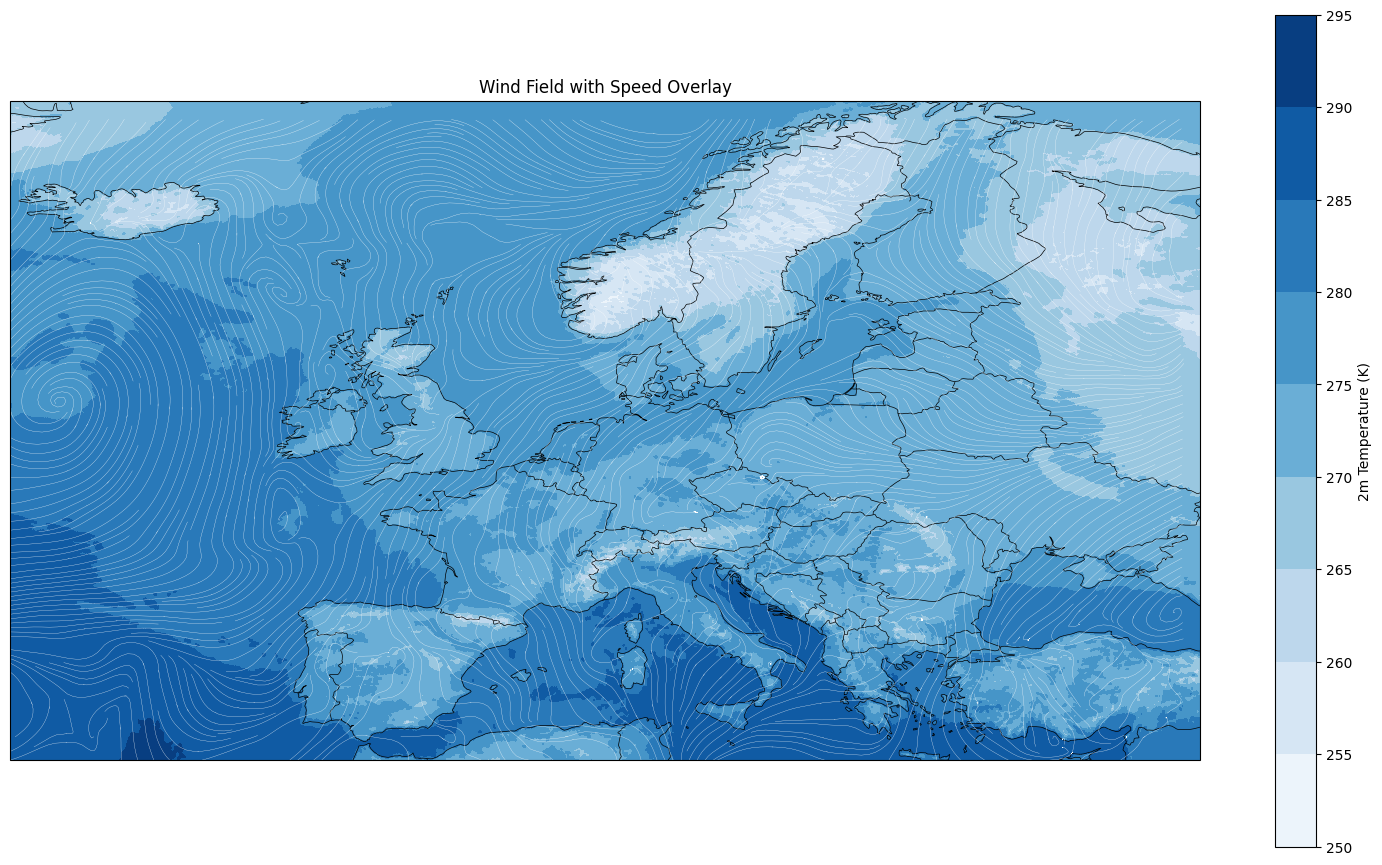

In [8]:
timestep = 0


# Extract wind components at the given timestep
u10 = hr_data['u10'].isel(time=timestep)
v10 = hr_data['v10'].isel(time=timestep)
lon = hr_data['longitude']
lat = hr_data['latitude']
t2m = hr_data['t2m'].isel(time=timestep)


# Subsample for visualization
step = 20
# Calculate wind speed
wind_speed = np.sqrt(u10**2 + v10**2)
lon_sub = lon[::step]
lat_sub = lat[::step]
u10_sub = u10[::step, ::step]
v10_sub = v10[::step, ::step]
wind_speed_sub = wind_speed[::step, ::step]

# Create a quiver plot with wind speed overlay
fig = plt.figure(figsize=(19.2, 10.8), dpi=100)  # Keep consistent 1080p resolution
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)

heatmap = ax.contourf(hr_data['longitude'], hr_data['latitude'], t2m,
                        cmap="Blues", transform=ccrs.PlateCarree())

stream = plt.streamplot(lon_sub, lat_sub, u10_sub, v10_sub, arrowstyle="-", color="white", density=5, linewidth=0.2)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Field with Speed Overlay')
plt.colorbar(heatmap, ax=ax, orientation="vertical", label="2m Temperature (K)")
plt.show()

In [9]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs

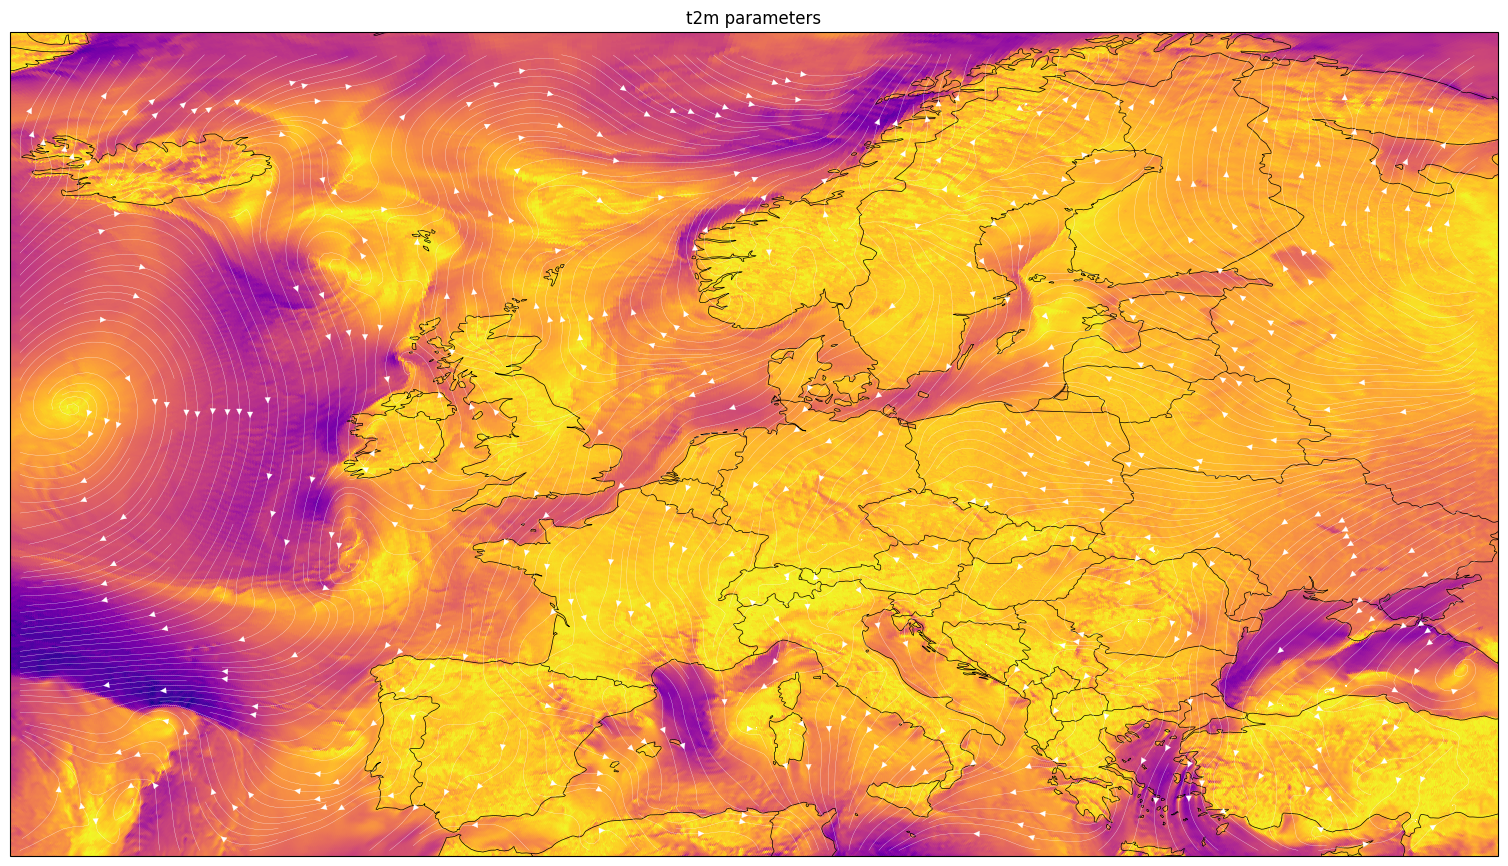

In [10]:

t2m = hr_data['t2m'].isel(time=timestep)  # Extract temperature at 2m

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)

heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], wind_speed,
                        cmap="plasma_r", transform=ccrs.PlateCarree())

# Initialize the streamplot
stream = ax.streamplot(lon_sub, lat_sub, u10_sub, v10_sub, color="white", density=5, linewidth=0.2)
# Get the segments of the streamlines
segments = stream.lines.get_segments()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')
plt.show()

In [11]:
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})

heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], wind_speed,
                        cmap="Blues", transform=ccrs.PlateCarree())


ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')

lengths = []
colors = []
lines = []
proj=ccrs.PlateCarree()

segments = stream.lines.get_segments()

for streamline in segments:

    s = streamline.T
    x, y = s[0], s[1]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n = len(segments)

    # Compute cumulative length along streamline
    D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
    L = D.cumsum().reshape(n, 1) + np.random.uniform(0, 1)

    # Create white color with gradient transparency
    C = np.ones((n, 4))  # (R=1, G=1, B=1, Alpha)
    C[:, 3] = np.linspace(0.0, 1.0, n)

    # Apply colors and transparency to LineCollection
    line = LineCollection(segments, colors=C, linewidth=0.5, transform=ccrs.PlateCarree())
    lengths.append(L)
    colors.append(C)
    lines.append(line)
    ax.add_collection(line)

def update(frame_no):
    for i in range(len(lines)):
        # Adjust movement based on wind speed (scaled appropriately)
        lengths[i] -= 0.05  # Move streamlines faster for higher wind speeds

        # Adjust transparency dynamically
        colors[i][::-1] = (lengths[i] * 1.5) % 1

        # Update streamline color
        lines[i].set_color(colors[i][::-1])

    pbar.update()


fig.tight_layout()

n = 10

animation = FuncAnimation(fig, update, frames=n, interval=10)
pbar = tqdm.tqdm(total=n)
animation.save('wind.mp4', writer='ffmpeg', fps=10)
pbar.close()
plt.close()

11it [00:13,  1.27s/it]                        


In [ ]:
# Test with ERA5
datasets = [
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-o2d-v0.zarr",
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-pl-v0.zarr",
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-ICON-0001-high-sfc-v0.zarr",
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr",
    "https://cacheb.dcms.destine.eu/era5/reanalysis-era5-land-no-antartica-v0.zarr",
    "https://cacheb.dcms.destine.eu/era5/reanalysis-era5-single-levels-v0.zarr",
]

In [13]:
url = "https://cacheb.dcms.destine.eu/era5/reanalysis-era5-single-levels-v0.zarr"
latitude_range = [35.0, 71.0]
longitude_range = [-25.0, 40.0]
start_date = "2020-03-01"
end_date = "2020-03-01"

data = xr.open_dataset(
    url,
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})

hr_data = data.sel(latitude=slice(latitude_range[1],latitude_range[0]),
                longitude=slice(longitude_range[0],longitude_range[1]),
                valid_time=slice(start_date, end_date))
hr_data

<xarray.Dataset> Size: 305MB
Dimensions:              (valid_time: 24, latitude: 145, longitude: 161)
Coordinates:
    depthBelowLandLayer  float64 8B ...
    entireAtmosphere     float64 8B ...
  * latitude             (latitude) float64 1kB 71.0 70.75 70.5 ... 35.25 35.0
  * longitude            (longitude) float64 1kB 0.0 0.25 0.5 ... 39.75 40.0
    number               int64 8B ...
    surface              float64 8B ...
  * valid_time           (valid_time) datetime64[ns] 192B 2020-03-01 ... 2020...
Data variables: (12/136)
    alnid                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    alnip                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    aluvd                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    aluvp                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    anor                 (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    asn                  (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    ...                   ...
    viiwn                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    vilwd                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    vilwe                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    vilwn                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    z                    (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    zust                 (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2025-02-13T19:28 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [ ]:
start_date = "2020-03-01"
end_date = "2020-03-01"

latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
hr_data = data.sel(latitude=slice(latitude_range[1],latitude_range[0]),
                longitude=slice(longitude_range[0],longitude_range[1]),
                valid_time=slice(start_date, end_date))

hr_data

<xarray.Dataset> Size: 305MB
Dimensions:              (valid_time: 24, latitude: 145, longitude: 161)
Coordinates:
    depthBelowLandLayer  float64 8B ...
    entireAtmosphere     float64 8B ...
  * latitude             (latitude) float64 1kB 71.0 70.75 70.5 ... 35.25 35.0
  * longitude            (longitude) float64 1kB 0.0 0.25 0.5 ... 39.75 40.0
    number               int64 8B ...
    surface              float64 8B ...
  * valid_time           (valid_time) datetime64[ns] 192B 2020-03-01 ... 2020...
Data variables: (12/136)
    alnid                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    alnip                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    aluvd                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    aluvp                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    anor                 (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    asn                  (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    ...                   ...
    viiwn                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    vilwd                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    vilwe                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    vilwn                (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    z                    (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
    zust                 (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(24, 52, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2025-02-13T19:28 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [14]:
hr_data = hr_data[["t2m", "u10", "v10","skt"]].load()
hr_data = hr_data.load()

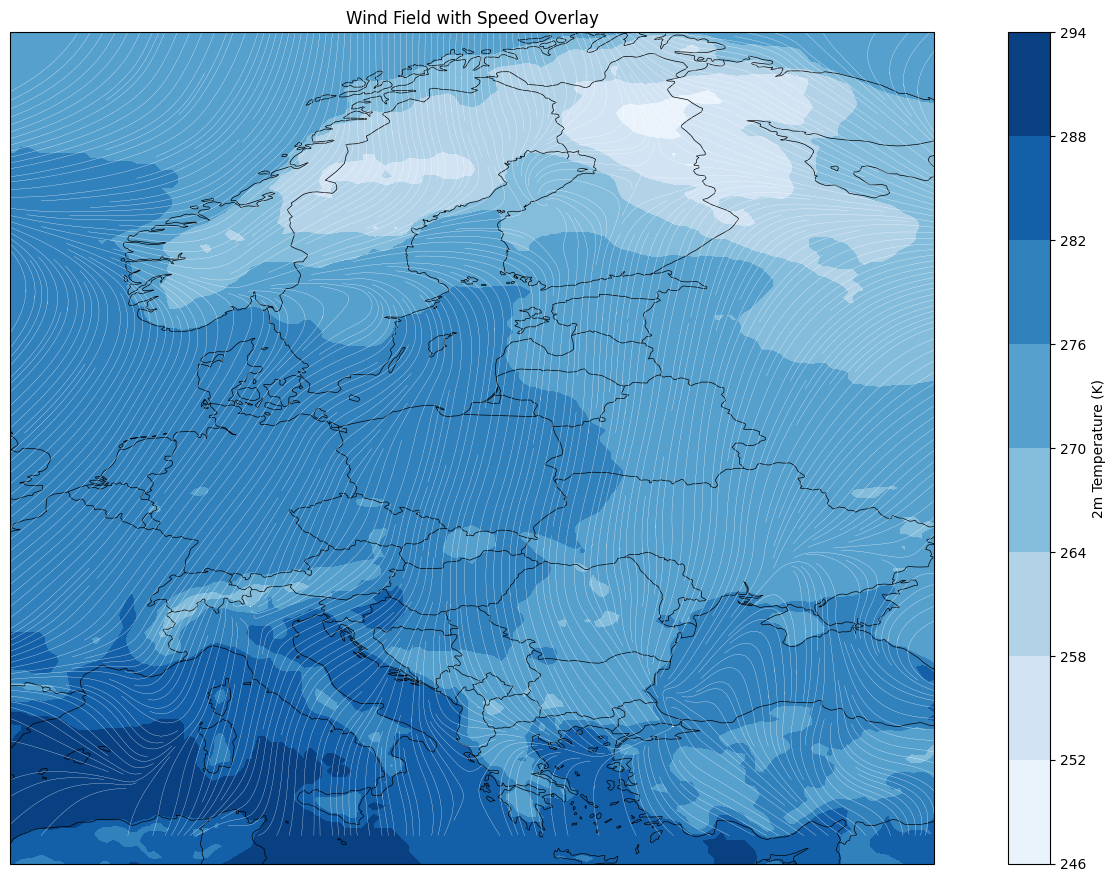

In [16]:
timestep = 0


# Extract wind components at the given timestep
u10 = hr_data['u10'].isel(valid_time=timestep)
v10 = hr_data['v10'].isel(valid_time=timestep)
lon = hr_data['longitude']
lat = hr_data['latitude']
t2m = hr_data['t2m'].isel(valid_time=timestep)


# Subsample for visualization
step = 20
# Calculate wind speed
wind_speed = np.sqrt(u10**2 + v10**2)
lon_sub = lon[::step]
lat_sub = lat[::step]
u10_sub = u10[::step, ::step]
v10_sub = v10[::step, ::step]
wind_speed_sub = wind_speed[::step, ::step]

# Create a quiver plot with wind speed overlay
fig = plt.figure(figsize=(19.2, 10.8), dpi=100)  # Keep consistent 1080p resolution
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)

heatmap = ax.contourf(hr_data['longitude'], hr_data['latitude'], t2m,
                        cmap="Blues", transform=ccrs.PlateCarree())

stream = plt.streamplot(lon_sub, lat_sub, u10_sub, v10_sub, arrowstyle="-", color="white", density=5, linewidth=0.2)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Field with Speed Overlay')
plt.colorbar(heatmap, ax=ax, orientation="vertical", label="2m Temperature (K)")
plt.show()

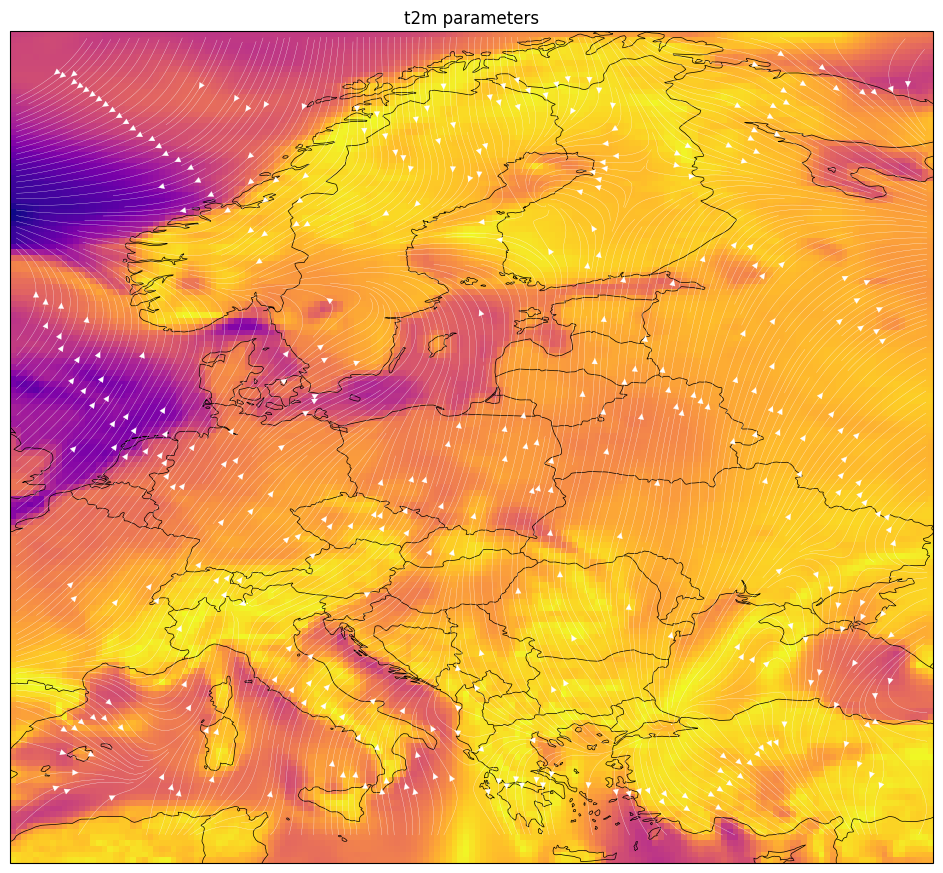

In [17]:

t2m = hr_data['t2m'].isel(valid_time=timestep)  # Extract temperature at 2m

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)

heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], wind_speed,
                        cmap="plasma_r", transform=ccrs.PlateCarree())

# Initialize the streamplot
stream = ax.streamplot(lon_sub, lat_sub, u10_sub, v10_sub, color="white", density=5, linewidth=0.2)
# Get the segments of the streamlines
segments = stream.lines.get_segments()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})

heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], wind_speed,
                        cmap="Blues", transform=ccrs.PlateCarree())


ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')

lengths = []
colors = []
lines = []
proj=ccrs.PlateCarree()

segments = stream.lines.get_segments()

for streamline in segments:

    s = streamline.T
    x, y = s[0], s[1]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n = len(segments)

    # Compute cumulative length along streamline
    D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
    L = D.cumsum().reshape(n, 1) + np.random.uniform(0, 1)

    # Create white color with gradient transparency
    C = np.ones((n, 4))  # (R=1, G=1, B=1, Alpha)
    C[:, 3] = np.linspace(0.0, 1.0, n)

    # Apply colors and transparency to LineCollection
    line = LineCollection(segments, colors=C, linewidth=0.5, transform=ccrs.PlateCarree())
    lengths.append(L)
    colors.append(C)
    lines.append(line)
    ax.add_collection(line)

def update(frame_no):
    for i in range(len(lines)):
        # Adjust movement based on wind speed (scaled appropriately)
        lengths[i] -= 0.05  # Move streamlines faster for higher wind speeds

        # Adjust transparency dynamically
        colors[i][::-1] = (lengths[i] * 1.5) % 1

        # Update streamline color
        lines[i].set_color(colors[i][::-1])

    pbar.update()


fig.tight_layout()

n = 10

animation = FuncAnimation(fig, update, frames=n, interval=10)
pbar = tqdm.tqdm(total=n)
animation.save('era_wind.mp4', writer='ffmpeg', fps=10)
pbar.close()
plt.close()

11it [00:05,  1.93it/s]                        
